In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"beproject4545","key":"1061fca9a0e7dedb82e26cbaa05ff232"}'}

In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d adityajn105/flickr8k

!unzip -q flickr8k.zip

100% 1.04G/1.04G [00:49<00:00, 23.3MB/s]
100% 1.04G/1.04G [00:49<00:00, 22.4MB/s]


In [17]:
# Importing Libraries
import numpy as np
import pandas as pd
import re
import nltk
import pickle
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3
from tensorflow.keras.layers import Input, Dense, Embedding, GRU, Concatenate, Reshape
from tensorflow.keras import Model, Sequential

In [18]:
# Constants
AUTOTUNE = tf.data.experimental.AUTOTUNE
vocab_size = 5000
sequence_length = 25
embedding_dim = 256
units = 512
batch_size = 128
epochs = 15
img_size = 224
channels = 3

# Directories
images = "Dataset/Images/"
captions = "Dataset/captions.txt"

In [19]:
# Read dataset, Rename columns, Drop null rows, Convert data type of comment_id

cap_df = pd.read_csv(captions, delimiter=",")

cap_df.dropna(axis=0, inplace=True)

def get_all_attributes(group):
    group_attributes = group.drop('image', axis=1).reset_index(drop=True)
    return group_attributes

# Group by 'Group' and apply the custom function
result = cap_df.groupby('image').apply(get_all_attributes)

# Reset the index to have a cleaner output
result.reset_index(inplace=True)

print(result)

                           image  level_1  \
0      1000268201_693b08cb0e.jpg        0   
1      1000268201_693b08cb0e.jpg        1   
2      1000268201_693b08cb0e.jpg        2   
3      1000268201_693b08cb0e.jpg        3   
4      1000268201_693b08cb0e.jpg        4   
...                          ...      ...   
40450   997722733_0cb5439472.jpg        0   
40451   997722733_0cb5439472.jpg        1   
40452   997722733_0cb5439472.jpg        2   
40453   997722733_0cb5439472.jpg        3   
40454   997722733_0cb5439472.jpg        4   

                                                 caption  
0      A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building .  
2       A little girl climbing into a wooden playhouse .  
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a

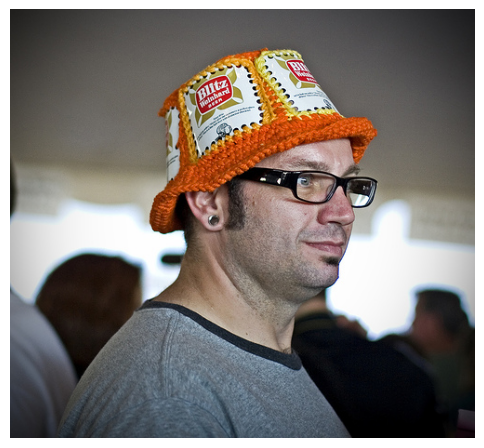

Captions for image 1007129816_e794419615.jpg:
- A man in an orange hat starring at something .
- A man wears an orange hat and glasses .
- A man with gauges and glasses is wearing a Blitz hat .
- A man with glasses is wearing a beer can crocheted hat .
- The man with pierced ears is wearing glasses and an orange hat .


In [20]:
image_path = "1007129816_e794419615.jpg"

# Select rows based on the condition
selected_rows = cap_df[cap_df["image"].str.contains(image_path)]

# Check if any rows are selected
if not selected_rows.empty:
    # Show image
    plt.figure(figsize=(6, 6))
    img = plt.imread("Dataset/Images/" + image_path)
    plt.axis("off")
    plt.imshow(img)
    plt.show()

    # Print all captions for the selected image
    print(f"Captions for image {image_path}:")
    for index, row in selected_rows.iterrows():
        caption = row["caption"]
        print(f"- {caption}")

else:
    print(f"Image {image_path} not found in the dataset.")

In [21]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
# Clean Text
lemmatizer = WordNetLemmatizer()
def clean_text(sent):
    sent = sent.lower()
    sent = re.sub("[0-9]","",sent)     # digits
    sent = re.sub("https?://\S+","",sent)     # URLs
    sent = re.sub("@\S+","",sent)     # @'s
    sent = re.sub("[+-/*,':%$#&!_<>(){}^]","",sent)     # special characters
    sent = re.sub(" +"," ",sent)     # extra spaces
    words = nltk.word_tokenize(sent)
    stop_words = set(nltk.corpus.stopwords.words("english"))
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    sent = ' '.join(words)
    sent = "[start] " + sent + " [end]"
    return sent

cap_df["caption"] = cap_df["caption"].apply(lambda x: clean_text(x))

In [23]:
# Create Sentence Vectorizer
sent_vectorization = TextVectorization(
    max_tokens = vocab_size, output_mode = "int", output_sequence_length = sequence_length
)
sent_vectorization.adapt(cap_df["caption"].values)

# Index to Word mapping
index_to_word = dict()
for index, word in enumerate(sent_vectorization.get_vocabulary()):
    index_to_word[index] = word

In [24]:
# Define Dataset Function
def image_read(path):
    path = "Dataset/Images/" + path
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels = channels)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (img_size, img_size))
    img = tf.keras.applications.efficientnet_v2.preprocess_input(img)
    return img

In [26]:
def process_text(sentences):
    caption_vector = sent_vectorization(sentences)
    return caption_vector

In [27]:
def create_dataset(images, texts, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((images, texts))
    dataset = dataset.map(lambda a, b : (image_read(a), process_text(b)), num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [28]:
cap_df = cap_df.sample(frac=1, random_state=42)
split_index = int(0.8 * len(cap_df))

trn = cap_df[:split_index]
tst = cap_df[split_index:]

print("Training set shape:", trn.shape)
print("Testing set shape:", tst.shape)

# Create datasets using create_dataset
train = create_dataset(trn["image"].values, trn["caption"].values, batch_size)
test = create_dataset(tst["image"].values, tst["caption"].values, batch_size)

Training set shape: (32364, 2)
Testing set shape: (8091, 2)


In [29]:
# EfficientNet for image context
base_model = EfficientNetV2B3(input_shape = (img_size, img_size, 3), include_top=False, weights="imagenet")
base_model.trainable = False
base_model_out = base_model.output
base_model_out = tf.keras.layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
cnn_model = Model(base_model.input, base_model_out)

# CNN_encoder for fine tuning
class CNN_encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_encoder, self).__init__()
        self.dense = Dense(embedding_dim, activation = "softmax")

    def call(self, img_context):
        x = self.dense(img_context)
        return x

52606240/52606240 [==============================] - 3s 0us/step


In [30]:
# Attention Class
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.units = units
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.S = Dense(1)

    def call(self, features, hidden):
        hidden_state_with_time_axis = tf.expand_dims(hidden, 1)

        attention_hidden_layer = tf.nn.tanh(self.W1(features) +
                                            self.W2(hidden_state_with_time_axis))

        score = self.S(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score, axis = 1)

        context_vector = features * attention_weights
        context_vector = tf.reduce_sum(context_vector, axis = 1)
        return context_vector

In [31]:
# RNN_encoder for sentence creation
class RNN_decoder(tf.keras.Model):
    def __init__(self, embedding_size, vocab_size, units):
        super(RNN_decoder, self).__init__()
        self.units = units
        self.attention = Attention(units)
        self.embedding = Embedding(vocab_size, embedding_size)
        self.gru = GRU(units,
                       return_sequences = True,
                       return_state = True)
        self.dense1 = Dense(units)
        self.dense2 = Dense(vocab_size)

    def call(self, x, features, hidden_state):
        context_vector = self.attention(features, hidden_state)
        x = self.embedding(x)
        x = tf.concat([x, tf.expand_dims(context_vector, 1)], axis = -1)
        x, states = self.gru(x)
        x = self.dense1(x)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.dense2(x)
        return x, states

In [32]:
encoder = CNN_encoder(embedding_dim)
decoder = RNN_decoder(embedding_dim, vocab_size, units)

optimizer = tf.keras.optimizers.Adam()
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

# Custom loss function
# Ignores the prediction of [mask] values
def loss_fn(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    final_loss = loss_obj(real, pred)

    mask = tf.cast(mask, dtype = final_loss.dtype)
    final_loss *= mask

    return tf.reduce_sum(final_loss)

In [33]:
# For each Batch
def train_step(img_tensor, target):
    loss = 0
    dec_input = tf.expand_dims([int(sent_vectorization('[start]')[0])] * target.shape[0], 1)
    hidden_state = tf.zeros((batch_size, units))

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            pred, hidden_state = decoder(dec_input, features, hidden_state)
            loss += loss_fn(target[:, i], pred)

            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = loss / int(target.shape[1])
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))

    return total_loss

In [34]:
# Train model
for epoch in range(epochs):
    total_loss = 0

    for imgs, target in train:
        img_tensor = cnn_model(imgs)
        loss = train_step(img_tensor, target)
        total_loss += loss

    print("##### Epoch {} #####".format(epoch + 1))
    print("Loss is {}".format(total_loss / len(trn)),"\n")

##### Epoch 1 #####
Loss is 1.3764394521713257 

##### Epoch 2 #####
Loss is 1.1396253108978271 

##### Epoch 3 #####
Loss is 1.0462902784347534 

##### Epoch 4 #####
Loss is 0.9857810735702515 

##### Epoch 5 #####
Loss is 0.9405767917633057 

##### Epoch 6 #####
Loss is 0.9029057621955872 

##### Epoch 7 #####
Loss is 0.8697999715805054 

##### Epoch 8 #####
Loss is 0.8409353494644165 

##### Epoch 9 #####
Loss is 0.815250813961029 

##### Epoch 10 #####
Loss is 0.7923676371574402 

##### Epoch 11 #####
Loss is 0.771899402141571 

##### Epoch 12 #####
Loss is 0.7535851001739502 

##### Epoch 13 #####
Loss is 0.7365372180938721 

##### Epoch 14 #####
Loss is 0.7211101651191711 

##### Epoch 15 #####
Loss is 0.706405758857727 



In [35]:
# Save weights of Model and Vectorizer
encoder.save_weights("encoder_weights.h5")
decoder.save_weights("decoder_weights.h5")

sent_vectorization_config = sent_vectorization.get_config()
sent_vectorization_weights = sent_vectorization.get_weights()

with open("sent_vectorizer.pkl", "wb") as f:
    pickle.dump({'config': sent_vectorization_config, 'weights': sent_vectorization_weights}, f)

In [36]:
# Caption function for evaluation
def caption(path):
    img = image_read(path)
    img = tf.expand_dims(img, 0)
    context = cnn_model(img)
    features = encoder(context)

    dec_input = tf.expand_dims([int(sent_vectorization('[start]')[0])], 0)
    hidden_state = tf.zeros((1, units))
    sentence = []
    for i in range(20):
        pred, hidden_state = decoder(dec_input, features, hidden_state)
        predicted_id = np.argmax(tf.reshape(pred, -1))
        predicted_word = index_to_word[predicted_id]
        sentence.append(predicted_word)

        if predicted_word == "end":
            return ' '.join(sentence[:-1])

        dec_input = tf.expand_dims([predicted_id], 0)
    return ' '.join(sentence)

small child crossing road 

scuba diver snorkel mask swim underwater holding small lobster 

two young boy standing front red ball 

dog water 

two people swim trunk standing shore 

person snowboarding hill 

little boy eating corndogs 

two people boat 

group child play game 

group people stand front museum standing front window 



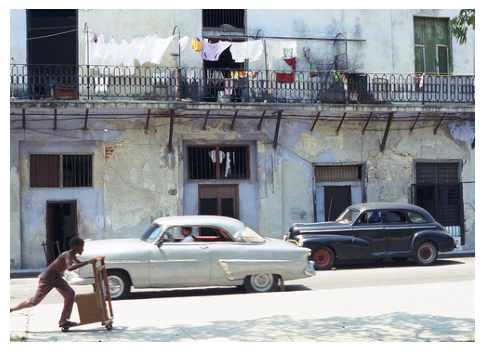

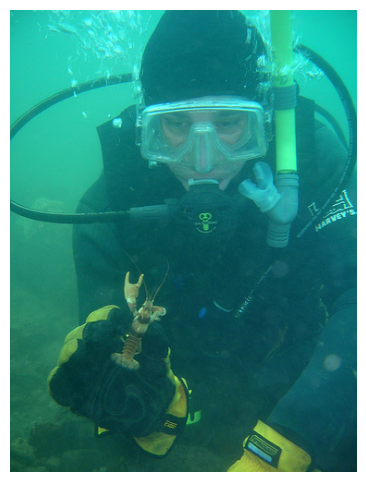

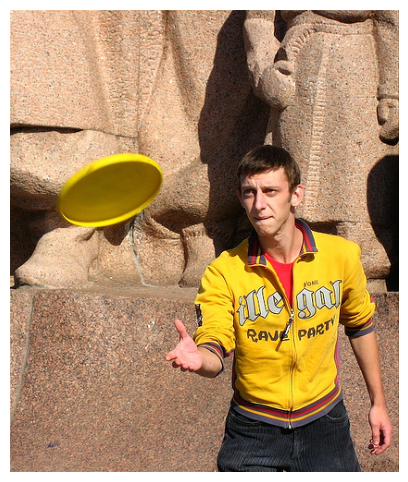

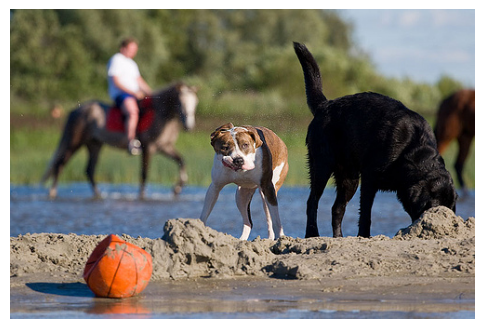

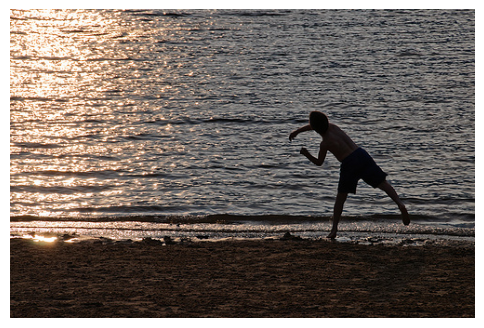

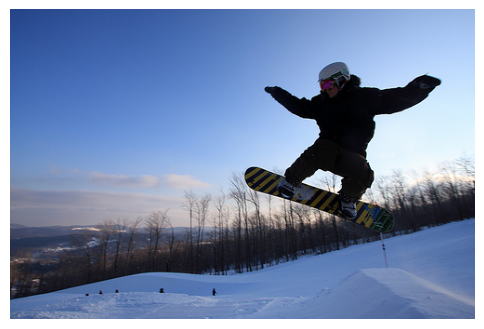

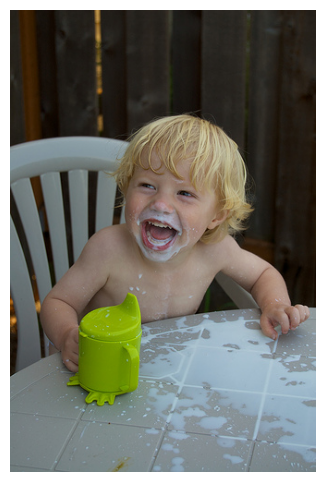

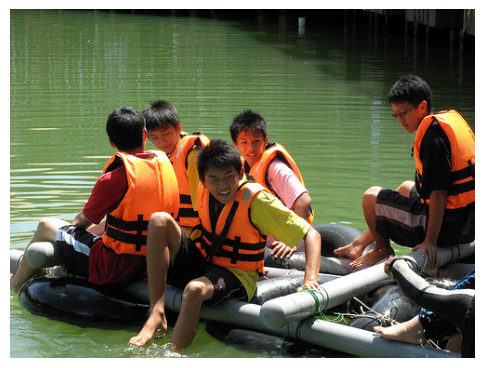

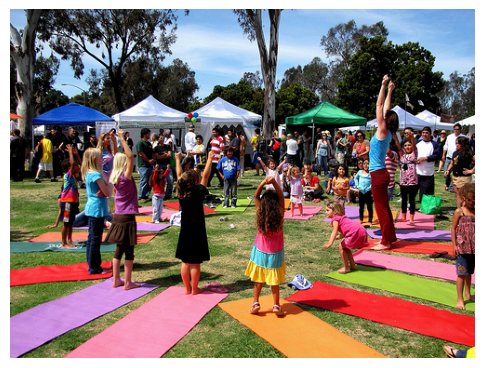

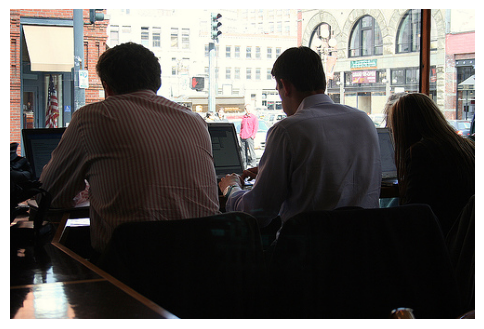

In [40]:
import matplotlib.pyplot as plt

def display_image_and_caption(dataset, index):
    # Display image
    plt.figure(figsize=(6, 6))
    img_path = "Dataset/Images/" + dataset["image"].iloc[index]
    img = plt.imread(img_path)
    plt.axis("off")
    plt.imshow(img)

    # Generate and print caption
    pred = caption(dataset["image"].iloc[index])
    print(pred, "\n")

for i in range(10):
    display_image_and_caption(tst, i)

In [41]:
# Bleu score function
def BLEU_score(real, pred):
    x = real.split()
    y = pred.split()

    smooth = SmoothingFunction().method4
    bleu = sentence_bleu([x[1:-1]], y, smoothing_function = smooth)
    return bleu

In [42]:
# Evaluate on Test Data
# BLEU score the Higher the Better
bleu = 0
num_batches = 0
for i in range(tst.shape[0]):
    num_batches+=1
    test_img = tst["image"].iloc[i]
    test_target = tst["caption"].iloc[i]
    prediction = caption(test_img)
    bleu += BLEU_score(test_target, prediction)

print("BLEU score is {}".format(bleu / num_batches))

BLEU score is 0.049999726824085496


In [43]:
# BLEU score function
def BLEU_score(real, pred, n):
    x = real.split()
    y = pred.split()

    smooth = SmoothingFunction().method4
    weights = [1.0 / n] * n  # Equal weights for BLEU1, BLEU2, BLEU3, BLEU4
    bleu = sentence_bleu([x[1:-1]], y, weights=weights, smoothing_function=smooth)
    return bleu

In [44]:
# Evaluate on Test Data
# BLEU score the Higher the Better
bleu1 = 0
bleu2 = 0
bleu3 = 0
bleu4 = 0
num_batches = 0

for i in range(tst.shape[0]):
    num_batches += 1
    test_img = tst["image"].iloc[i]
    test_target = tst["caption"].iloc[i]
    prediction = caption(test_img)

    bleu1 += BLEU_score(test_target, prediction, 1)
    bleu2 += BLEU_score(test_target, prediction, 2)
    bleu3 += BLEU_score(test_target, prediction, 3)
    bleu4 += BLEU_score(test_target, prediction, 4)

average_bleu1 = bleu1 / num_batches
average_bleu2 = bleu2 / num_batches
average_bleu3 = bleu3 / num_batches
average_bleu4 = bleu4 / num_batches

print("BLEU1 score is {}".format(average_bleu1))
print("BLEU2 score is {}".format(average_bleu2))
print("BLEU3 score is {}".format(average_bleu3))
print("BLEU4 score is {}".format(average_bleu4))

BLEU1 score is 0.19964277683478615
BLEU2 score is 0.10774086216963331
BLEU3 score is 0.06960997962735037
BLEU4 score is 0.049999726824085496
